# Fruit Classifier Sandbox

- Sandbox to test out any of our augmentations.
- Settings are commented out and provide a selection to use.
- Maybe you can obtain a better result with the variations in settings we created!

# Setup

In [1]:
# import libs
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import random
from PIL import Image
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

## Core Variables

In [2]:
# Global variables

channel_dict = {
    'RGB' : 3,
    'RGBcanny' : 4,
    'Grayscale' : 1,
    'Canny' : 1
}

fruit_array = ["apple","banana", "orange", "mixed"]

seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

reset_variables_dict = {
    #default variables
    'img_size' : 224,
    'epochs' : 64,
    'batchsize' : 10, 
    'validation_split' :0.1,
    'patience_value' : 5 ,
    'retain_aspect_ratio' : False,
    'use_classweights' : True,
    'use_random_oversampling' : False,
    'var_model' : 'Optimal',
    'var_data' : '01RELABELLED',
    'var_aug' : ['RGB', None],
}

# Need to autosave to load model in later steps! Setting to false will break this.
is_autosave = True

# Functions

## Function Definitions (Image Layer Augmentation)

In [3]:
def first_augmentation_step(first_aug, img):
    '''
    For pre-processing image channels- Edge maps, color, etc.
    ALWAYS accept and return a PIL image
    ALWAYS return a PIL image, even if preprocessing with CV2
    '''

    if  first_aug=='RGB':
        return img
    
    elif first_aug=='RGBcanny':
        #convert to np ndarray
        PIL_array = np.array(img)

        ## debugging
        # print(type(PIL_array)) #np.ndarray
        # print(PIL_array.shape) #349,3

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        ## debugging
        # print(type(edges)) #np.ndarray
        # print(edges.shape) #349,

        final_img_array = np.dstack((PIL_array, edges))
        RGBwMap = Image.fromarray(final_img_array)
        return RGBwMap
    
    elif first_aug=='Grayscale':
        grayscale = img.convert('L')
        return grayscale
    
    elif first_aug=='Canny':
        PIL_array = np.array(img)

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        canny = Image.fromarray(edges)
        return canny
    
    else:
        print('ERROR: No image augmentation selected!')
    

## Function Definitions (Image Position Augmentation)

In [4]:
def second_augmentation_step(second_aug, img):
    '''
    For pre-processing image loci- translation, rotation, zooming, flipping 
    ALWAYS accept and return a PIL image
    '''

    second_aug_tuple = (
        "rotation",
        "translation",
        "zoom",
        "flip_horizontal",
        "flip_vertical",
        "flip_vertical_horizontal")
    
    # if no second aug, return
    if second_aug not in second_aug_tuple:
        return img
    
    # convert to preserve first aug
    if channels ==1:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2BGR)
    elif channels ==3:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_RGBA2BGR)
    elif channels==4:
        cv2_image = cv2.cvtColor(np.array(img),cv2.COLOR_RGBA2BGRA)

        
    if second_aug == "rotation":
        cv2_final_image = cv2.rotate(cv2_image,cv2.ROTATE_90_CLOCKWISE)

    elif second_aug == "translation":
        tx = 50
        ty = 30
        translation_matrix = np.array([[1,0,tx],
                                   [0,1,ty]], dtype=np.float32)
        cv2_final_image = cv2.warpAffine(src=cv2_image, M=translation_matrix,dsize=(img.size[0], img.size[1]))

    elif second_aug == "zoom":
        zf = 2
        rows, cols = img.size[1],img.size[0]
        new_rows = int(rows*zf)
        new_cols = int(cols*zf)
        cv2_final_image = cv2.resize(cv2_image,(new_rows,new_cols))
  
    elif second_aug=='flip_horizontal':
        # Flip the image horizontally
        cv2_final_image = cv2.flip(cv2_image, 1)
        
    elif second_aug=='flip_vertical':
        # Flip the image vertically
        cv2_final_image = cv2.flip(cv2_image, 0)
        
    elif second_aug=='flip_vertical_horizontal':
        cv2_flipped_vertc_image = cv2.flip(cv2_image, 0)
        cv2_final_image = cv2.flip(cv2_flipped_vertc_image, 1)


    # convert to preserve first aug
    if channels ==1:
        edited_image = Image.fromarray(
            cv2.cvtColor(cv2_final_image, 
                         cv2.COLOR_BGR2RGB))
        edited_image = edited_image.convert('L')
        
    elif channels ==3:
        edited_image = Image.fromarray(
            cv2.cvtColor(cv2_final_image, 
                         cv2.COLOR_BGR2RGB))
        
    elif channels==4:
        edited_image = Image.fromarray(
            cv2.cvtColor(
                cv2_final_image, 
                cv2.COLOR_BGRA2RGBA))
        

    return edited_image

## Function Definitions (Model Augmentation)

In [5]:
def create_model(input_dimension, channels, model_type=None, num_classifications=4):
    '''
    Create a model
    Use 'flatten' or 'pooling' depending on settings
    '''
    model = tf.keras.Sequential()
    num_classifications=num_classifications
    
    if model_type=='FewLayers':
        model.add(tf.keras.layers.Conv2D(
                filters=16,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(input_dimension, input_dimension, channels)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())

        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    elif model_type=='Overtuned':
        model.add(tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(input_dimension, input_dimension, channels)))
        model.add(tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2), (2, 2)))

        model.add(tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2), (2, 2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    elif model_type =='9x9':
        model.add(tf.keras.layers.Conv2D(64,(9,9),activation = 'relu',input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, (9,9), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))
        model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    elif model_type=='Optimal':
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))

        # 4 classifications- Apple, Banana, Orange, Mixed
        model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))
        model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])


    

    return model

## Function Definitions (Primary)

In [6]:
# define func

def show_image(X_train,index):
    '''
    Display the image at the specific index of the reshaped array
    '''
    if not index  < X_train.shape[0]:
        print("Array does not contain your desired image index.")
    image_array = X_train[index]
    image = Image.fromarray(np.uint8(image_array))
    image.show()

def prep_train_data(subfolder_name, desired_size, var_aug_type):
    new_size = desired_size
    paths = []
    is_train_data=True
    
    for fruit in fruit_array:
        paths.append('ML_Proj_Data/train/{subfolder}/{fruit}'.format(subfolder=subfolder_name,fruit=fruit))

    return prep_data(paths, new_size, var_aug_type, is_train_data)

def prep_test_data(desired_size, var_aug_type):
    new_size = desired_size
    paths = []
    is_train_data=False

    for fruit in fruit_array:
        paths.append('ML_Proj_Data/test/{fruit}'.format(fruit=fruit))

    return prep_data(paths, new_size, var_aug_type, is_train_data)

def prep_data(paths, desired_size, var_aug_type, is_train_data):
    '''
    Pre-process all images in each of the 4 paths.
    '''
    new_size = desired_size

    for i in range(len(paths)):
        data = read_img_data(paths[i],new_size, var_aug_type, is_train_data)
        
        #test if it works by showing image
        # show_image(data,0)
        # show_image(data,1)

        try: 
            # concatenate if initialized
            X = np.concatenate((X,data))
        except:
            # initialize if not
            X = data

        y_onehots = map_type_to_onehot(paths[i], data.shape[0])
        try:
            y = np.concatenate((y,y_onehots))
        except:
            y = y_onehots
        
    return X,y

def map_type_to_onehot(file_path, n_rows):
    '''
    Map the type of image to digit.
    Takes in a specific file path.
    Returns a onehot encoded 1D array.
    '''
    y_onehot = [0]*4
    fruit_onehot_dict =	{
    "apple": [1,0,0,0],
    "banana": [0,1,0,0],
    "orange": [0,0,1,0],
    "mixed": [0,0,0,1]
    }

    normalized_path = file_path.replace('\\','/')
    segments = normalized_path.split('/')
    final_segment = segments[-1]

    if '.jpg' in final_segment:
        # incorrect path structure but handle it anyway
        prefix = final_segment.split('_')[0]
    else:
        prefix = final_segment

    if prefix in fruit_onehot_dict:
        y_onehot =  fruit_onehot_dict[prefix]

    y_onehots = [y_onehot] * n_rows
    # convert python list to numpy array
    # as keras requires numpy array
    return np.array(y_onehots)

def read_img_data(path, desired_size, var_aug_type, is_train_data):
    '''
    Loops through every file in a specific path
    Opens, pre-processes, and adds each image to X_train
    '''

    for file in os.listdir(path):
        if file[0] == '.':  # skip hidden files
            continue

        img = Image.open("{path}/{file}".format(path=path,file=file))
        img = preprocess_image(img, desired_size, var_aug_type, is_train_data)
    
        try:
            # concatenate every subsequent img to x_train after it has been initialized at (i=0)
            X_train = np.concatenate((X_train, img))
        except:
            # initialize x_train and assign img to it as the first value if it does not exist (i=0)
            X_train = img

            #code for ndim canny map in channels in np.reshape
            channels=channel_dict[var_aug_type[0]]
    
    # returns the entire folder of images as a single array

    return np.reshape(X_train, (-1,desired_size,desired_size,channels))


def preprocess_image(img, desired_size, var_aug_type, is_train_data):
    '''
    Pre-process specific image object ONLY.
    Convert to RGB to reduce unnecessary features (remove alpha, ndim 4-> 3) and increase training speed.
    (!) must be for looped!
    '''
    # new 2D image size
    new_size = (desired_size,desired_size)

    # remove alpha channel
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
        #convert to RGBA to use alpha_composite function
        img = img.convert('RGBA')
        bg = Image.new('RGBA',img.size, (255, 255, 255))

        bg.alpha_composite(img, (0,0))
        img = bg.convert('RGB')

    if img.mode != 'RGB':
        img = img.convert('RGB')

    ##ASPECT RATIO CODE##
    if retain_aspect_ratio == True:
        background = Image.new('RGB', new_size,(255,255,255)) #white background

        #calculate the aspect ratio of augmented image
        img_ratio = img.width/img.height
        # print(img_ratio) #debug
        # Calculate the dimensions of the resized image based on the aspect ratio and the desired size
        if img_ratio > 1:
            #landscape image
            new_width = desired_size
            new_height = int(desired_size/img_ratio)
        else:
            #portrait or symmetrical image
            new_width = int(desired_size/img_ratio)
            new_height = desired_size

        # Resize image while retaining the aspect ratio
        img.thumbnail((new_width, new_height))
        #Calculate the absolute center to paste img onto background
        pos_x = (desired_size-img.width) //2
        pos_y = (desired_size-img.height) //2
        #Paste at calculated pos
        background.paste(img,(pos_x, pos_y))
        img = background
        img = img.resize(new_size)

    else:
        img = img.resize(new_size)
    ##END ASPECT RATIO CODE##

    img = first_augmentation_step(first_aug=var_aug_type[0], img=img)

    if is_train_data:
        img = second_augmentation_step(second_aug=var_aug_type[1], img=img)

    # resized_img = img.resize(new_size)
    return img

def assign_class_weights(use_classweights, y_data):
    if use_classweights:
        # Class weights calculation
        class_weights = {}

        y_data_copy = y_data.copy()
        y_data_copy = np.sum(y_data_copy, axis=0)
        total_class = float(len(y_data_copy))
        total_images = np.sum(y_data_copy)

        for i in range(len(y_data_copy)):
            class_weights[i] = (1/y_data_copy[i]) * (total_images/total_class)
    else:
        class_weights = {0:1,1:1,2:1,3:1}
        
    # print(class_weights)
    return class_weights

def random_oversampling(X, y):
    # Perform random oversampling
    oversampler = RandomOverSampler()
    X_resampled, y_resampled = oversampler.fit_resample(X.reshape(X.shape[0], -1), y)

    # Reshape X_resampled back to the original shape
    X_resampled = X_resampled.reshape(-1, img_size, img_size, X.shape[-1])

    return X_resampled, y_resampled

def save_model(model, path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    model.save(path)

def load_model(path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    return tf.keras.models.load_model(path)

def test_model(model, X_test, y_test):
    return model.evaluate(x=X_test, y=y_test)

def setup_graph_data(callback):
    tl = callback.history['loss']
    vl = callback.history['val_loss']
    ta = callback.history['accuracy']
    va = callback.history['val_accuracy']

    df_train_loss = pd.DataFrame({"training loss":tl,"validation loss":vl})
    df_train_acc = pd.DataFrame({"training accuracy":ta,"validation accuracy":va})
    return df_train_loss,df_train_acc

def save_plot(plt,path_fragment,plotname):
	path = 'ML_Proj_Data/model/{pathfragment}/{plotname}.png'.format(pathfragment=path_fragment, plotname=plotname)
	plt.savefig(path)


## Function Definitions (Utility)

In [7]:
def reset_instance_variables(reset_variables_dict):
    
    for var_name, var_value in reset_variables_dict.items():
        globals()[var_name] = var_value

    set_automatic_variables()


# Sandbox Model

## Instanced Variables

In [8]:

# Set Variables
img_size = 224
epochs = 64
batchsize= 10
validation_split=0.2
patience_value = 5
retain_aspect_ratio = True
use_classweights = True
use_random_oversampling = True

# Model Variant- See Function Definitions (Model Augmentation)
var_model = 'Optimal' 
    # OPTIONS: 
    # # 'FewLayers' # 'Overtuned' # 'Optimal' # '9x9'

# Data Variant- See \ML_Proj_Data\train
var_data = '03EXPANDED' 
    # OPTIONS: 
    # # '00BASE' # '01RELABELLED' # '02INCREASED' # '03EXPANDED'

# Augmentation Variant- See Function Definitions (Image Augmentation)
var_aug= ['RGBcanny', "flip_horizontal"]
    # OPTIONS: 
    # # First Aug
        #'RGB' # 'RGBcanny' # 'Grayscale' # 'Canny' 
    # # Second Aug
        #"rotation" #"translation" #"zoom" #"flip_horizontal" #"flip_vertical" #"flip_vertical_horizontal"


In [9]:
# Automatic Variables

def set_automatic_variables():
    global model_data_id 
    model_data_id = '[{model}]-[{data}]-[{imgaug01}]-[{imgaug02}]'.format(
        model=var_model,
        data=var_data,    
        imgaug01=var_aug[0],
        imgaug02=var_aug[1]) 
    global channels
    channels=channel_dict[var_aug[0]]

set_automatic_variables()

## Data Preparation

In [10]:
# Prep training, validation and test data

X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

if use_random_oversampling==True:
    X_data, y_data = random_oversampling(X_data, y_data)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

print('X_train: {X_train}, y_train: {y_train}'.format(X_train=X_train.shape, y_train=y_train.shape))
print('X_validate: {X_validate}, y_validate: {y_validate}'.format(X_validate=X_validate.shape, y_validate=y_validate.shape))
print('X_test: {X_test}, y_test: {y_test}'.format(X_test=X_test.shape, y_test=y_test.shape))

set_automatic_variables()

class_weights = assign_class_weights(use_classweights, y_data)
print("Class weights= {}".format(class_weights))


X_train: (320, 224, 224, 4), y_train: (320, 4)
X_validate: (80, 224, 224, 4), y_validate: (80, 4)
X_test: (60, 224, 224, 4), y_test: (60, 4)
Class weights= {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


## (Optional) Check Validation Set

In [11]:
# Check if validation sample is evenly distributed

# print(type(y_validate))
yv_urows, yv_counts = np.unique(y_validate, axis=0, return_counts=True)
print ("Onehots= {}".format(yv_urows))
print ("Onehot data distribution count= {}".format(yv_counts))

Onehots= [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
Onehot data distribution count= [20 20 20 20]


## Create and Fit Model

In [12]:
# Create
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()

save_path = 'ML_Proj_Data/model/{model}'.format(model=model_data_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

csv_logger = CSVLogger('{sp}/LOG-[{date}]-[{time}].csv'.format(
    sp=save_path,
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))

early_stopping = EarlyStopping(monitor='accuracy', patience=patience_value)

# Train and Save

callback = model.fit(x=X_train/255, 
                     y=y_train, 
                     batch_size=batchsize, 
                     epochs=epochs, 
                     validation_data=(X_validate/255,y_validate), 
                     callbacks = [early_stopping,csv_logger],
                     class_weight = class_weights)
save_model(model,model_data_id)

Epoch 1/64
32/32 [==============================] - 12s 51ms/step - loss: 1.3898 - accuracy: 0.2500 - val_loss: 1.3748 - val_accuracy: 0.4125
Epoch 2/64
32/32 [==============================] - 1s 22ms/step - loss: 1.3254 - accuracy: 0.4313 - val_loss: 1.0886 - val_accuracy: 0.5125
Epoch 3/64
32/32 [==============================] - 1s 23ms/step - loss: 1.1734 - accuracy: 0.4875 - val_loss: 1.0522 - val_accuracy: 0.4875
Epoch 4/64
32/32 [==============================] - 1s 22ms/step - loss: 1.1828 - accuracy: 0.5406 - val_loss: 1.0271 - val_accuracy: 0.6500
Epoch 5/64
32/32 [==============================] - 1s 21ms/step - loss: 1.0390 - accuracy: 0.5562 - val_loss: 0.8420 - val_accuracy: 0.6750
Epoch 6/64
32/32 [==============================] - 1s 21ms/step - loss: 0.8792 - accuracy: 0.6875 - val_loss: 0.7876 - val_accuracy: 0.7000
Epoch 7/64
32/32 [==============================] - 1s 22ms/step - loss: 0.7810 - accuracy: 0.7281 - val_loss: 0.4379 - val_accuracy: 0.8750
Epoch 8/64
3

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_horizontal]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Optimal]-[03EXPANDED]-[RGBcanny]-[flip_horizontal]\assets


## Evaluate Model Against Test Data

In [13]:
# Test against Cher Wah's Test Data
model = load_model(model_data_id)
test_result= test_model(model, X_test/255, y_test)

#Autosave
if is_autosave:
    df = pd.DataFrame(test_result)
    path = 'ML_Proj_Data/model/{pathfragment}/{testname}.csv'.format(pathfragment=model_data_id, testname='evaluationtest')
    df.to_csv(path)


2/2 [==============================] - 1s 382ms/step - loss: 0.3022 - accuracy: 0.9000


## Graph Data Setup

In [14]:
# Prepare DataFrames for Graphing

df_train_loss, df_train_acc= setup_graph_data(callback)

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())

(26, 2)
    training loss  validation loss
21       0.177098         0.195982
22       0.196866         0.249379
23       0.190336         0.124830
24       0.239659         0.334866
25       0.171627         0.354296
(26, 2)
    training accuracy  validation accuracy
21           0.928125               0.9500
22           0.928125               0.9125
23           0.943750               0.9375
24           0.934375               0.8875
25           0.937500               0.9125


## Graph Model Performance

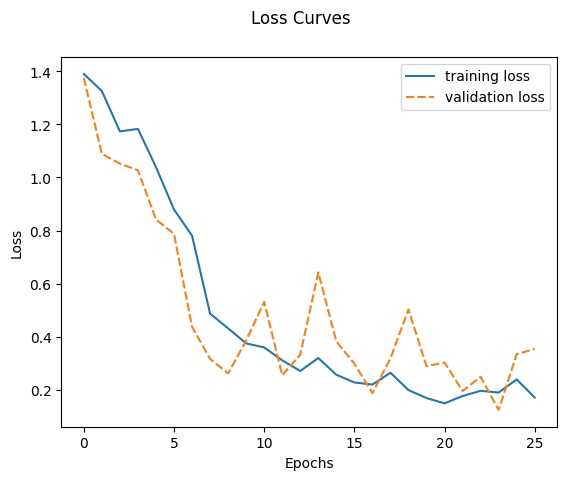

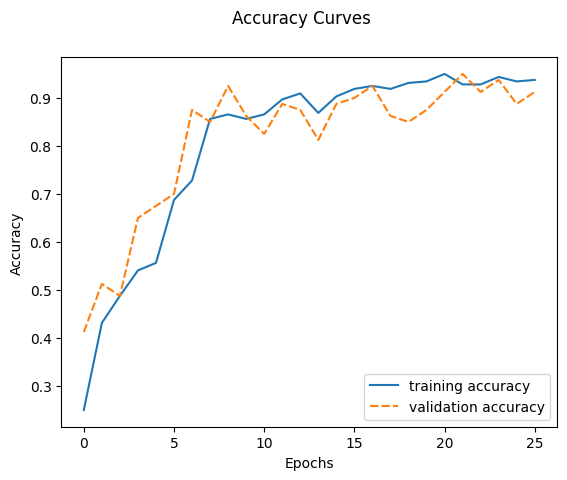

In [15]:
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'LossCurve')
plt.show()


sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
if is_autosave:
    save_plot(plt, model_data_id, 'AccCurve')
plt.show()


## Heat Maps

2/2 [==============================] - 0s 15ms/step


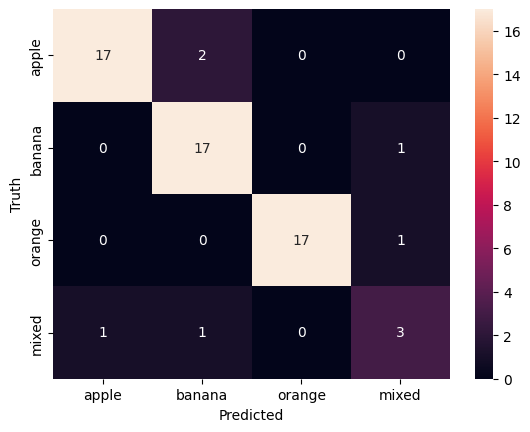

In [16]:
y_pred = model.predict(X_test/255)
y_truth = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_truth, y_pred)
sns.heatmap(
    cm,
    xticklabels=fruit_array,
    yticklabels=fruit_array,
    annot=True)

plt.xlabel("Predicted")
plt.ylabel("Truth")
if is_autosave:
    save_plot(plt, model_data_id, 'HeatMap')